In [6]:
import os
import sys
import math
import glob
import json
import yaml
import time
import torch
import warnings
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path
from os.path import join as pjoin

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# base_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
base_path = os.path.dirname(os.path.abspath("."))
sys.path.append(base_path)

from dataset import TLESS_Dataset
from lib import network, rendering
from evaluation import utils
from evaluation import config as cfg

# this function is borrowed from https://github.com/thodan/sixd_toolkit/blob/master/pysixd/inout.py
def save_results_sixd17(path, res, run_time=-1):

    txt = 'run_time: ' + str(run_time) + '\n' # The first line contains run time
    txt += 'ests:\n'
    line_tpl = '- {{score: {:.8f}, ' \
                   'R: [' + ', '.join(['{:.8f}'] * 9) + '], ' \
                   't: [' + ', '.join(['{:.8f}'] * 3) + ']}}\n'
    for e in res['ests']:
        Rt = e['R'].flatten().tolist() + e['t'].flatten().tolist()
        txt += line_tpl.format(e['score'], *Rt)
    with open(path, 'w') as f:
        f.write(txt)

# gpu_id = 0
gpu_id = 1

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
os.environ['EGL_DEVICE_ID'] = str(gpu_id)
DEVICE = torch.device('cuda')

datapath = Path(cfg.DATA_PATH)

cfg.DATASET_NAME = 'tless'   # dataset name
eval_dataset = TLESS_Dataset.Dataset(datapath / cfg.DATASET_NAME)
cfg.RENDER_WIDTH = eval_dataset.cam_width        # the width of rendered images
cfg.RENDER_HEIGHT = eval_dataset.cam_height      # the height of rendered imagescd

# cfg.USE_ICP = False
# cfg.USE_VPNMS = False


# cfg.VP_NUM_TOPK = 50   # the retrieval number of viewpoint 
cfg.POSE_NUM_TOPK = 1  # the ranking number of full 3D orientation 

ckpt_file = pjoin(base_path, 
                'checkpoints', 
                "narvi_maxPool_detach_pose_model_50_121526_11_02-05:39:36_0.0046_0.0198_5.3.pth"
                )
model_net = network.OVE6D().to(DEVICE)

model_net.load_state_dict(torch.load(ckpt_file), strict=True)
model_net.eval()

codebook_saving_dir = pjoin(base_path,'evaluation/object_codebooks',
                            cfg.DATASET_NAME, 
                            'zoom_{}'.format(cfg.ZOOM_DIST_FACTOR), 
                            'views_{}'.format(str(cfg.RENDER_NUM_VIEWS)))


object_codebooks = utils.OVE6D_codebook_generation(codebook_dir=codebook_saving_dir, 
                                                    model_func=model_net,
                                                    dataset=eval_dataset, 
                                                    config=cfg, 
                                                    device=DEVICE)

Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_01_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_02_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_03_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_04_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_05_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_06_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/zoom_0.01/views_4000/tless_obj_07_views_4000.npy
Loading  /home/dingding/Workspace/OVE6D_release/evaluation/object_codebooks/tless/z

In [269]:
test_data_dir = datapath / 'tless' / 'test_primesense'
rcnn_mask_dir = datapath / 'tless' / 'mask_RCNN_50'

obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)

for scene_id in sorted(os.listdir(test_data_dir))[4:]:
    scene_dir = pjoin(test_data_dir, scene_id)
    if not os.path.isdir(scene_dir):
        continue

    cam_info_file = pjoin(scene_dir, 'scene_camera.json')
    with open(cam_info_file, 'r') as cam_f:
        scene_camera_info = json.load(cam_f)
    
    scene_mask_dir = pjoin(rcnn_mask_dir, "{:02d}".format(int(scene_id)))
    scene_rcnn_file = pjoin(scene_mask_dir, 'mask_rcnn_predict.yml')
    with open(scene_rcnn_file, 'r') as rcnn_f:
        scene_detect_info = yaml.load(rcnn_f, Loader=yaml.FullLoader)
    
#     gt_bbox_file = os.path.join(scene_dir, 'scene_gt_info.json')
#     with open(gt_bbox_file, 'r') as bbox_f:
#         bbox_anno = json.load(bbox_f)
        
    gt_pose_file = os.path.join(scene_dir, 'scene_gt.json')
    with open(gt_pose_file, 'r') as pose_f:
        pose_anno = json.load(pose_f)
        
    rgb_dir = pjoin(scene_dir, 'rgb')
    depth_dir = pjoin(scene_dir, 'depth')
    mask_dir = pjoin(scene_dir, 'mask_visib')
    view_runtime = list()
    for depth_png in sorted(os.listdir(depth_dir))[100:]:
        if not depth_png.endswith('.png'):
            continue
        view_id = int(depth_png.split('.')[0])           # 000000.png
        view_rcnn_ret = scene_detect_info[view_id]       # scene detection results
        view_cam_info = scene_camera_info[str(view_id)]  # scene camera information
        
        
        ## read all object masks 
        view_gt_masks = list()
        obj_msk_files = glob.glob(pjoin(mask_dir, "{:06d}_*.png".format(int(view_id))))
        for obj_msk_f in sorted(obj_msk_files):
            gt_obj_msk = torch.from_numpy(np.array(Image.open(obj_msk_f), dtype=np.uint8))
            view_gt_masks.append(gt_obj_msk)
        view_gt_masks = torch.stack(view_gt_masks, dim=0)
        view_gt_pose = pose_anno[str(view_id)] # obj poses in a view
        
        

        depth_file = pjoin(depth_dir, depth_png)
        mask_file = pjoin(scene_mask_dir, 'masks', '{}.npy'.format(view_id))  # 0000001.npy
        view_masks = torch.tensor(np.load(mask_file), dtype=torch.float32)
        view_depth = torch.from_numpy(np.array(Image.open(depth_file), dtype=np.float32))
        
        view_depth *= view_cam_info['depth_scale']
        view_camK = torch.tensor(view_cam_info['cam_K'], dtype=torch.float32).view(3, 3)[None, ...] # 1x3x3
        view_timer = time.time()
        
        cam_K = view_camK.to(DEVICE)
        
        img_name = "{:06d}.png".format(view_id)
        rgb_file = os.path.join(rgb_dir, img_name)
        pil_img = Image.open(rgb_file)
        rgb_img = np.array(pil_img)
        
#         if len(view_gt_pose) != len(view_rcnn_ret):
#             continue
        
        for obj_rcnn in view_rcnn_ret[3:]: # estimate the detected objects
            obj_timer = time.time()
            chan = obj_rcnn['np_channel_id']
            obj_id = obj_rcnn['obj_id']
            obj_conf = obj_rcnn['score']
            if obj_conf < 0:  # only consider the valid detected objects
                continue
            if len(view_masks.shape) == 2:
                obj_mask = view_masks
            else:
                obj_mask = view_masks[:, :, chan] # 1xHxW  
                
            NN = len(view_gt_masks)
            iou_cnt, iou_idx = (view_gt_masks * obj_mask).view(NN, -1).sum(dim=1).topk(k=NN)
            
            gt_ix = iou_idx[0]
            obj_pose = view_gt_pose[gt_ix]
            obj_gt_R = cfg.BOP_REF_POSE(torch.tensor(obj_pose['cam_R_m2c'], dtype=torch.float32).view(3, 3))
            obj_gt_t = torch.tensor(obj_pose['cam_t_m2c'], dtype=torch.float32) * cfg.MODEL_SCALING

            
            obj_depth = view_depth * obj_mask
            obj_depth = obj_depth * cfg.MODEL_SCALING # from mm to meter
            obj_codebook = object_codebooks[obj_id]
            obj_depth = obj_depth.unsqueeze(0)
            obj_mask = obj_mask.unsqueeze(0)
            pose_ret = utils.OVE6D_mask_full_pose(model_func=model_net, 
                                                obj_depth=obj_depth,
                                                obj_mask=obj_mask,
                                                obj_codebook=obj_codebook, 
                                                cam_K=view_camK,
                                                config=cfg, 
                                                device=DEVICE,
                                                obj_renderer=obj_renderer)
            break
        break
    break
del obj_renderer



raw_pose_R = pose_ret['raw_R']
raw_pose_t = pose_ret['raw_t']

icp1_pose_R = pose_ret['icp1_R']
icp1_pose_t = pose_ret['icp1_t']

icpk_pose_R = pose_ret['icpk_R']
icpk_pose_t = pose_ret['icpk_t']

# raw_R_err = torch.arccos(torch.trace(raw_pose_R@obj_gt_R.T)/2.0-0.5) / math.pi * 180
# icp1_R_err = torch.arccos(torch.trace(icp1_pose_R@obj_gt_R.T)/2.0-0.5) / math.pi * 180
# icpk_R_err = torch.arccos(torch.trace(icpk_pose_R@obj_gt_R.T)/2.0-0.5) / math.pi * 180
# print(raw_R_err, icp1_R_err, icpk_R_err)



raw_R_err = utils.rotation_error(raw_pose_R, obj_gt_R)
icp1_R_err = utils.rotation_error(icp1_pose_R, obj_gt_R)
icpk_R_err = utils.rotation_error(icpk_pose_R, obj_gt_R)

raw_t_err = raw_pose_t - obj_gt_t
icp1_t_err = icp1_pose_t - obj_gt_t
icpk_t_err = icpk_pose_t - obj_gt_t

print(raw_R_err, raw_t_err*1000)
print(icp1_R_err, icp1_t_err*1000)
print(icpk_R_err, icpk_t_err*1000)


tensor([[[ 0.3318, -0.7614,  0.5569],
         [ 0.9377,  0.3310, -0.1060],
         [-0.1036,  0.5574,  0.8238]]])
tensor(7.7946) tensor([[-0.9572,  0.8773, -3.0895]])
tensor(2.2590) tensor([ 1.7073,  4.1910, -0.7654])
tensor(2.2590) tensor([ 1.7073,  4.1910, -0.7654])


In [272]:
raw_vp_err = torch.arccos((raw_pose_R[2] * obj_gt_R[2]).sum())/math.pi * 180
icp1_vp_err = torch.arccos((icp1_pose_R[2] * obj_gt_R[2]).sum())/math.pi * 180
icpk_vp_err = torch.arccos((icpk_pose_R[2] * obj_gt_R[2]).sum())/math.pi * 180
print(raw_vp_err, icp1_vp_err, icpk_vp_err)


VP_R = torch.tensor([
   [ 0.3318, -0.7614,  0.5569],
         [ 0.9377,  0.3310, -0.1060],
         [-0.1036,  0.5574,  0.8238]
    
    ])


tensor(7.4134) tensor(nan) tensor(nan)


/home/hdd/Dingding/Dataspace/BOP_Dataset/tless/test_primesense/000005/rgb/000100.png


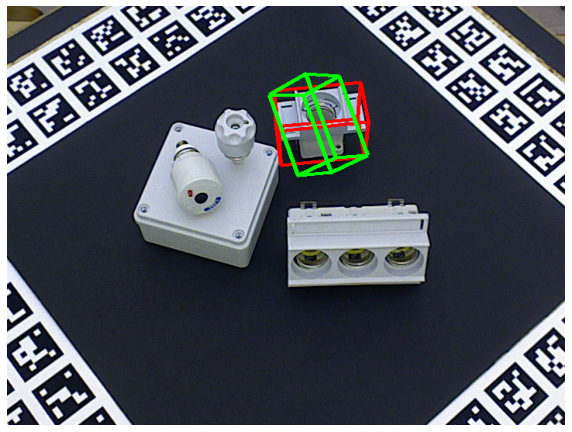

In [274]:

def box_2D_shape(points, pose, K):
    canonical_homo_pts = torch.tensor(vert2_to_bbox8(points).T, dtype=torch.float32)
    trans_homo = pose @ canonical_homo_pts
    homo_K = torch.zeros((3, 4), dtype=torch.float32)
    homo_K[:3, :3] = torch.tensor(K, dtype=torch.float32)
    bbox_2D = (homo_K @ trans_homo)
    bbox_2D = (bbox_2D[:2] / bbox_2D[2]).T.type(torch.int32)#.tolist()
    return bbox_2D


def vert2_to_bbox8(corner_pts, homo=True):
    pts = list()
    for i in range(2):
        for j in range(2):
            for k in range(2):
                if homo:
                    pt = [corner_pts[i, 0], corner_pts[j, 1], corner_pts[k, 2], 1.0]
                else:
                    pt = [corner_pts[i, 0], corner_pts[j, 1], corner_pts[k, 2]]
                pts.append(pt)   
    return np.asarray(pts)

def bbox_to_shape(bbox_2D):
    connect_points = [[0, 2, 3, 1, 0], [0, 4, 6, 2], [2, 3, 7, 6], [6, 4, 5, 7], [7, 3, 1, 5]]
    shape = list()
    for plane in connect_points:
        for idx in plane:
            point = (bbox_2D[idx][0], bbox_2D[idx][1])
            shape.append(point)
    return shape


obj_mesh = obj_codebook['obj_mesh']
corner_pts = obj_mesh.bounds

GT_pose = torch.eye(4, dtype=torch.float32)
GT_pose[:3, :3] = obj_gt_R
GT_pose[:3, 3] = obj_gt_t


PD_raw_pose = torch.eye(4, dtype=torch.float32)
PD_raw_pose[:3, 3] = raw_pose_t
PD_raw_pose[:3, :3] = cfg.POSE_TO_BOP(raw_pose_R)


PD_icp1_pose = torch.eye(4, dtype=torch.float32)
PD_icp1_pose[:3, 3] = icp1_pose_t
PD_icp1_pose[:3, :3] = cfg.POSE_TO_BOP(icp1_pose_R)


PD_icpk_pose = torch.eye(4, dtype=torch.float32)
PD_icpk_pose[:3, 3] = icpk_pose_t
PD_icpk_pose[:3, :3] = cfg.POSE_TO_BOP(icpk_pose_R)


Rxy_pose = torch.eye(4, dtype=torch.float32)
Rxy_pose[:3, :3] = cfg.POSE_TO_BOP(VP_R)
Rxy_pose[:3, 3] = raw_pose_t


GT_2D_bbox = box_2D_shape(points=corner_pts, pose=GT_pose, K=cam_K)
PD_VP_2D_bbox = box_2D_shape(points=corner_pts, pose=Rxy_pose, K=cam_K)

PD_raw_2D_bbox = box_2D_shape(points=corner_pts, pose=PD_raw_pose, K=cam_K)
PD_icp1_2D_bbox = box_2D_shape(points=corner_pts, pose=PD_icp1_pose, K=cam_K)
PD_icpk_2D_bbox = box_2D_shape(points=corner_pts, pose=PD_icpk_pose, K=cam_K)


GT_shape = bbox_to_shape(GT_2D_bbox.tolist())
PD_VP_shape = bbox_to_shape(PD_VP_2D_bbox.tolist())

PD_raw_shape = bbox_to_shape(PD_raw_2D_bbox.tolist())
PD_icp1_shape = bbox_to_shape(PD_icp1_2D_bbox.tolist())
PD_icpk_shape = bbox_to_shape(PD_icpk_2D_bbox.tolist())

# Rxy_shape = bbox_to_shape(Rxy_2D_bbox.tolist())


from PIL import ImageDraw, Image

RGB_bbox_img = Image.fromarray(rgb_img.copy())

draw = ImageDraw.Draw(RGB_bbox_img)
draw.line(GT_shape, (255, 0, 0), 5)  # red for GT

# draw.line(PD_raw_shape, (0, 0, 255), 5)  # blue

draw.line(PD_VP_shape, (0, 255, 0), 5)  # blue


# draw.line(PD_icp1_shape, (0, 255, 0), 5)  # green
# 
# draw.line(PD_icpk_shape, (255, 0, 255), 5)  # cyan

print(rgb_file)
RGB_bbox_img

plt.figure(figsize=(10, 10))
plt.axis(False)
plt.imshow(RGB_bbox_img)


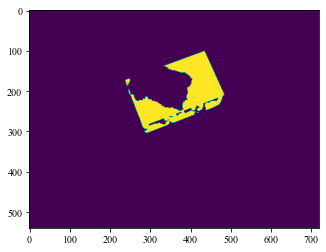

In [253]:
plt.imshow(view_gt_masks[gt_ix])

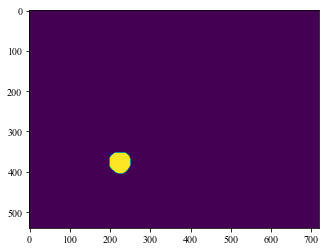

In [19]:
plt.imshow(obj_mask.squeeze())

# Liu

In [275]:
print(11)

11
